## Gradient boosted trees predictive model in a machine learning pipeline
In machine learning tasks, several modules and algorithms are composed into a sequential workflow. In Spark the concept of a 'Pipeline' was introduced which allows us to build such workflows.
The main concepts in Spark Pipelines are explained in the 
[Spark ML-Guide](http://spark.apache.org/docs/latest/ml-guide.html)

In this notebook, we are using the 'Bike Buyer' dataset provided by Valentine Fontama in
his 'Buyer Propensity Model' experiment.
This can be found in the Cortana Intelligence Gallery:
[Buyer Propensity Model](http://gallery.cortanaintelligence.com/Experiment/Buyer-Propensity-Model-2)

In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

In [2]:
# stop active context and start a new instance
sca = SparkContext._active_spark_context
if sca:
    sca.stop()
sc = SparkContext()


### Loading the dataset

In [3]:
# load the bike buyer dataset, skip header line
bbFileLocation = 'file:/datasets/BikeBuyerWithLocation.csv'
bbData = sc.textFile(bbFileLocation)
bbHeader = bbData.first()
bbData = bbData.filter(lambda x: x != bbHeader)
print "Data size is {}".format(bbData.count())
bbData.take(2)

Data size is 10000


[u'29476,Married,Female,20000,0,Partial College,Manual,No,1,0-1 Miles,Europe,47,Yes,31.42728,151.40989,Skegness,U8H 3NI,United Kingdom',
 u'29472,Married,Female,10000,1,High School,Manual,No,1,1-2 Miles,Europe,46,No,-49.777,-57.09436,Krefeld,38010,Germany']

### Preparing the dataset
There are some columns with missing values. That might cause problems in machine learning
algorithms. Therefore, we prepare the dataset for future use.

In [4]:
# Prepare the dataset
# Convert label to 0/1 (as double)
def convertYesNo(strlabel):
    lbl = 0.0
    if (strlabel == 'Yes'):
        lbl = 1.0
    return lbl

# Country not specified for regions North America / Pacific
# In these cases we use the region instead, since empty names are not allowed
def convertCountry(strCountry, strRegion):
    strCountryOut = strCountry
    if (strCountry == ""):
        strCountryOut = strRegion    
    return strCountryOut

# Parse data and create data frames
from pyspark.sql import Row

parts = bbData.map(lambda l: l.split(",", -1))
# select relevant columns for further processing
features = parts.map(lambda p: (convertYesNo(p[12]),p[1],p[2],p[3],p[4],p[5],p[6],
                                p[7], p[8], p[9], p[10],p[11],
                                convertCountry(p[17], p[10])))
featuresRows = features.map(lambda p: Row(label=p[0], MaritalStatus=p[1], Gender=p[2],
                                         YearlyIncome=p[3], Children=p[4], Education=p[5],
                                         Occupation=p[6], HomeOwner=p[7], Cars=p[8],
                                         CommuteDistance=p[9], Region=p[10], Age=p[11],
                                         Country=p[12]))

# sc is an existing spark context
sqlContext = SQLContext(sc)

# Register the DataFrame as a table
dfBB = sqlContext.createDataFrame(featuresRows)
dfBB.registerTempTable("bikebuyers")
dfBB.printSchema()

root
 |-- Age: string (nullable = true)
 |-- Cars: string (nullable = true)
 |-- Children: string (nullable = true)
 |-- CommuteDistance: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HomeOwner: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- YearlyIncome: string (nullable = true)
 |-- label: double (nullable = true)



In [5]:
# display the first two rows
dfBB.take(2)

[Row(Age=u'47', Cars=u'1', Children=u'0', CommuteDistance=u'0-1 Miles', Country=u'United Kingdom', Education=u'Partial College', Gender=u'Female', HomeOwner=u'No', MaritalStatus=u'Married', Occupation=u'Manual', Region=u'Europe', YearlyIncome=u'20000', label=1.0),
 Row(Age=u'46', Cars=u'1', Children=u'1', CommuteDistance=u'1-2 Miles', Country=u'Germany', Education=u'High School', Gender=u'Female', HomeOwner=u'No', MaritalStatus=u'Married', Occupation=u'Manual', Region=u'Europe', YearlyIncome=u'10000', label=0.0)]

#### Cast numeric features to double

In [6]:
dfBB = dfBB.withColumn("IntAgeTmp", dfBB.Age.cast('double')) \
            .drop("Age") \
            .withColumnRenamed("IntAgeTmp", "Age")
dfBB = dfBB.withColumn("IntCarsTmp", dfBB.Cars.cast('double')) \
            .drop("Cars") \
            .withColumnRenamed("IntCarsTmp", "Cars")
dfBB = dfBB.withColumn("IntChildrenTmp", dfBB.Children.cast('double')) \
            .drop("Children") \
            .withColumnRenamed("IntChildrenTmp", "Children")
dfBB = dfBB.withColumn("IntYearlyIncomeTmp", dfBB.YearlyIncome.cast('double')) \
            .drop("YearlyIncome") \
            .withColumnRenamed("IntYearlyIncomeTmp", "YearlyIncome")     
        
dfBB.take(2)

[Row(CommuteDistance=u'0-1 Miles', Country=u'United Kingdom', Education=u'Partial College', Gender=u'Female', HomeOwner=u'No', MaritalStatus=u'Married', Occupation=u'Manual', Region=u'Europe', label=1.0, Age=47.0, Cars=1.0, Children=0.0, YearlyIncome=20000.0),
 Row(CommuteDistance=u'1-2 Miles', Country=u'Germany', Education=u'High School', Gender=u'Female', HomeOwner=u'No', MaritalStatus=u'Married', Occupation=u'Manual', Region=u'Europe', label=0.0, Age=46.0, Cars=1.0, Children=1.0, YearlyIncome=10000.0)]

With pandas we can show the first five records in a pretty table format.

In [7]:
# With pandas we can show the first five records in a pretty table format
import pandas as pd
pd.DataFrame(dfBB.take(5),columns=dfBB.columns).transpose()

,0,1,2,3,4
CommuteDistance,0-1 Miles,1-2 Miles,2-5 Miles,1-2 Miles,2-5 Miles
Country,United Kingdom,Germany,United Kingdom,France,United Kingdom
Education,Partial College,High School,High School,High School,Partial College
Gender,Female,Female,Female,Male,Male
HomeOwner,No,No,No,No,No
MaritalStatus,Married,Married,Single,Single,Single
Occupation,Manual,Manual,Manual,Manual,Manual
Region,Europe,Europe,Europe,Europe,Europe
label,1,0,0,0,0
Age,47,46,46,46,64


#### One-hot encoding: convert categorical features to numerical ones

In [8]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
MaritalStatusIndexer = StringIndexer(inputCol="MaritalStatus", outputCol="indMaritalStatus")
MaritalStatusEncoder = OneHotEncoder(inputCol="indMaritalStatus", outputCol="vecMaritalStatus")
GenderIndexer = StringIndexer(inputCol="Gender", outputCol="indGender")
GenderEncoder = OneHotEncoder(inputCol="indGender", outputCol="vecGender")
HomeOwnerIndexer = StringIndexer(inputCol="HomeOwner", outputCol="indHomeOwner")
HomeOwnerEncoder = OneHotEncoder(inputCol="indHomeOwner", outputCol="vecHomeOwner")
EducationIndexer = StringIndexer(inputCol="Education", outputCol="indEducation")
EducationEncoder = OneHotEncoder(inputCol="indEducation", outputCol="vecEducation")
OccupationIndexer = StringIndexer(inputCol="Occupation", outputCol="indOccupation")
OccupationEncoder = OneHotEncoder(inputCol="indOccupation", outputCol="vecOccupation")
CommuteDistanceIndexer = StringIndexer(inputCol="CommuteDistance", 
                                       outputCol="indCommuteDistance")
CommuteDistanceEncoder = OneHotEncoder(inputCol="indCommuteDistance", 
                                       outputCol="vecCommuteDistance")
RegionIndexer = StringIndexer(inputCol="Region", outputCol="indRegion")
RegionEncoder = OneHotEncoder(inputCol="indRegion", outputCol="vecRegion")
CountryIndexer = StringIndexer(inputCol="Country", outputCol="indCountry")
CountryEncoder = OneHotEncoder(inputCol="indCountry", outputCol="vecCountry")


In [9]:
# set up a pipeline for one-hot-encoding
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
featureAssembler = VectorAssembler(inputCols=["Age","Children","Cars","YearlyIncome",
                                            "vecMaritalStatus","vecGender",
                                            "vecHomeOwner", "vecEducation",
                                            "vecOccupation","vecCommuteDistance", "vecRegion",
                                            "vecCountry"],
                                  outputCol="features")
pipelineOHE = Pipeline(stages=[MaritalStatusIndexer, MaritalStatusEncoder, 
                               GenderIndexer, GenderEncoder, 
                               HomeOwnerIndexer, HomeOwnerEncoder,
                               EducationIndexer, EducationEncoder,
                               OccupationIndexer, OccupationEncoder,
                               CommuteDistanceIndexer, CommuteDistanceEncoder,
                               RegionIndexer, RegionEncoder, CountryIndexer, CountryEncoder,
                                featureAssembler])
modelOHE = pipelineOHE.fit(dfBB)
featuresOHE = modelOHE.transform(dfBB).select("features")
featuresOHE.show()

+--------------------+
|            features|
+--------------------+
|(25,[0,2,3,4,7,15...|
|(25,[0,1,2,3,4,9,...|
|(25,[0,1,2,3,9,20...|
|(25,[0,1,2,3,5,9,...|
|(25,[0,2,3,5,7,20...|
|(25,[0,2,3,8,14,2...|
|(25,[0,3,10,14,15...|
|(25,[0,2,3,6,8,14...|
|(25,[0,3,4,6,8,14...|
|(25,[0,3,5,6,7,15...|
|(25,[0,3,5,6,8,15...|
|(25,[0,3,4,6,10,1...|
|(25,[0,3,5,6,10,1...|
|(25,[0,3,4,6,10,1...|
|(25,[0,3,4,5,6,10...|
|(25,[0,3,10,14,15...|
|(25,[0,3,8,15,20]...|
|(25,[0,3,4,5,6,8,...|
|(25,[0,3,4,6,8,15...|
|(25,[0,2,3,7,14,1...|
+--------------------+
only showing top 20 rows



In [10]:
# show first record in dfBB
print "First record in the dataset"
print dfBB.first()

First record in the dataset
Row(CommuteDistance=u'0-1 Miles', Country=u'United Kingdom', Education=u'Partial College', Gender=u'Female', HomeOwner=u'No', MaritalStatus=u'Married', Occupation=u'Manual', Region=u'Europe', label=1.0, Age=47.0, Cars=1.0, Children=0.0, YearlyIncome=20000.0)


In [11]:
# show encoded features of first record in dfBB
print "Corresponding one-hot encoded features"
print featuresOHE.first()

Corresponding one-hot encoded features
Row(features=SparseVector(25, {0: 47.0, 2: 1.0, 3: 20000.0, 4: 1.0, 7: 1.0, 15: 1.0, 20: 1.0, 23: 1.0}))


**Note:** We have prepared a separate notebook covering one-hot encoding in more detail.

### Split the dataset into a training and testing dataset

In [12]:
# split data into training and testing data
weights = [.8,.2]
seed = 42
dfTrain, dfTest = dfBB.randomSplit(weights, seed)

### Set up the Machine Learning Pipeline
We set up a machine learning pipeline with several modules including the 'Gradient Boosted Trees Regressor' (`gbtr`) acting as an 'Estimator'.
The `gbtr` is fit on the training dataset `dfTrain`. The resulting `gbtrModel` is a 'Transformer' which is applied to the testing dataset `dfTest` to obtain the predictions.

In [13]:
# Gradient boosted trees regressor
from pyspark.ml.regression import GBTRegressor
from pyspark.mllib.evaluation import BinaryClassificationMetrics

gbtr = GBTRegressor(maxIter=10, maxDepth=5, labelCol="label")
pipelineGBTR = Pipeline(stages=[MaritalStatusIndexer, MaritalStatusEncoder, 
                            GenderIndexer, GenderEncoder, 
                            HomeOwnerIndexer, HomeOwnerEncoder,
                            EducationIndexer, EducationEncoder,
                            OccupationIndexer, OccupationEncoder,
                            CommuteDistanceIndexer, CommuteDistanceEncoder,
                            RegionIndexer, RegionEncoder, CountryIndexer, CountryEncoder,
                            featureAssembler, gbtr])
gbtrModel = pipelineGBTR.fit(dfTrain)
gbtrPredictionAndLabels = gbtrModel.transform(dfTest).select("prediction", "label") \
                                .map(lambda x: (x.prediction, x.label))
# compute metrics
gbtrMetrics = BinaryClassificationMetrics(gbtrPredictionAndLabels)
print("AUC %.3f" %gbtrMetrics.areaUnderROC)

AUC 0.747


### Cross-validation

In [14]:
# Try to improve accuracy using cross-validation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

gbtrCV = GBTRegressor(maxIter=10, maxDepth=5, labelCol="label")
pipelineCV = Pipeline(stages=[MaritalStatusIndexer, MaritalStatusEncoder, 
                            GenderIndexer, GenderEncoder, 
                            HomeOwnerIndexer, HomeOwnerEncoder,
                            EducationIndexer, EducationEncoder,
                            OccupationIndexer, OccupationEncoder,
                            CommuteDistanceIndexer, CommuteDistanceEncoder,
                            RegionIndexer, RegionEncoder, CountryIndexer, CountryEncoder,
                            featureAssembler, gbtrCV])
evaluator = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",
                                             metricName="precision")
paramGrid = ParamGridBuilder() \
                .addGrid(gbtrCV.maxIter, [10,20]) \
                .addGrid(gbtrCV.maxDepth, [5,7,9]) \
                .build()
numFolds = 4
crossval = CrossValidator(
    estimator = pipelineCV,
    estimatorParamMaps = paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

cvModel = crossval.fit(dfTrain)
cvPredictionAndLabels = cvModel.transform(dfTest).select("prediction", "label") \
                                .map(lambda x: (x.prediction, x.label))
# compute metrics
cvMetrics = BinaryClassificationMetrics(cvPredictionAndLabels)
print("AUC %.3f" %cvMetrics.areaUnderROC)

AUC 0.747


### From scores to predictions


Let's have a look into the predictions and labels obtained from our model.

In [15]:
# prediction contains raw prediction scores
cvPredictionAndLabels.take(2)

[(0.0788530549175131, 0.0), (0.009343923027113392, 0.0)]

As we can see, the predictions are in double format. If we start a marketing campaign, we want to know which customers are most likely to buy the product. If the score is low, e.g. 0.00934,
there is little chance that the customer will buy the product. So we have to set a threshold between 0 and 1 to filter out the people we want to address in the marketing campaign.

There is a tradeoff between accuracy and true positives. If the threshold is low, accuracy is low but the number of true positives (bike buyers in our case) is higher.

In [16]:
# convert scores to 0/1 according to threshold
def labelPredict(prediction, threshold):
    lbl = 0.0
    if prediction >= threshold:
        lbl = 1.0
    return lbl

# set threshold < .5 for more true positives
threshold = 0.25
cvPredictions = cvModel.transform(dfTest).select("prediction", "label") \
            .map(lambda x: Row(prediction=labelPredict(x.prediction, threshold), label=x.label))
cvPredictions = sqlContext.createDataFrame(cvPredictions)
cvAccuracy = cvPredictions.filter(cvPredictions['label'] == cvPredictions['prediction']).count()
cvAccuracy = cvAccuracy / float(cvPredictions.count())
print cvAccuracy


0.893649193548


In [17]:
print("Threshold %.3f" % threshold) 
nTP = cvPredictions.filter(cvPredictions['label'] == 1.0) \
    .filter(cvPredictions['prediction'] == 1.0) \
    .count()
print("True positives %.0f" % nTP)
nFP = cvPredictions.filter(cvPredictions['label'] == 0.0) \
    .filter(cvPredictions['prediction'] == 1.0) \
    .count()
print("False positives %.0f" % nFP)
nTN = cvPredictions.filter(cvPredictions['label'] == 0.0) \
    .filter(cvPredictions['prediction'] == 0.0) \
    .count()
print("True negatives %.0f" % nTN) 
nFN = cvPredictions.filter(cvPredictions['label'] == 1.0) \
    .filter(cvPredictions['prediction'] == 0.0) \
    .count()
print("False negatives %.0f" % nFN)




Threshold 0.250
True positives 36
False positives 54
True negatives 1737
False negatives 157


### Visualization
The confusion matrix can be shown as a pie chart.
[see Machine learning: Predictive analysis on food inspection data using MLlib with Spark on HDInsight Linux (Preview)](https://github.com/Azure/azure-content/blob/master/articles/hdinsight/hdinsight-apache-spark-machine-learning-mllib-ipython.md)

(-1.0065430165737945, 1.0, -1.0039534770963663, 1.0062651460344028)

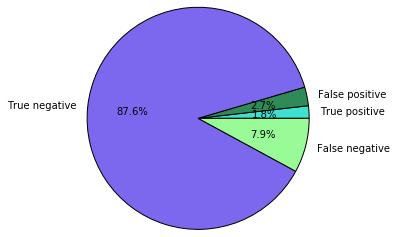

In [18]:
# Visualize confusion matrix
%matplotlib inline
import matplotlib.pyplot as plt
labels = ["True positive", "False positive", "True negative", "False negative"]
sizes = [nTP, nFP, nTN, nFN]
colors = ["turquoise", "seagreen", "mediumslateblue", "palegreen", "coral"]
plt.pie(sizes,labels=labels,autopct="%1.1f%%", colors=colors)
plt.axis("equal")